In [1]:
#!pip install tensorflow keras split-folders opencv-python

In [27]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as numpy
import splitfolders
import cv2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
import os
import random

In [3]:
input_folder = "bloodcells_dataset"
output_folder = "image_recognition"

In [4]:
split_ratio = (0.8, 0.1, 0.1)
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=split_ratio,
    group_prefix=None
)   # Cria as pastas test, train e val no image_recognition


Copying files: 17092 files [00:05, 2990.78 files/s]


In [5]:
# Define the parameters
img_size = (360, 363)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,    # resnet50
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
train_dir = os.path.join(output_folder, 'train')
test_dir = os.path.join(output_folder, 'test')
valid_dir = os.path.join(output_folder, 'val')

In [8]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 13671 images belonging to 8 classes.
Found 1716 images belonging to 8 classes.
Found 1705 images belonging to 8 classes.


In [9]:
valid_data

In [10]:
# Get a batch of images and labels
images, labels = next(valid_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..131.32].


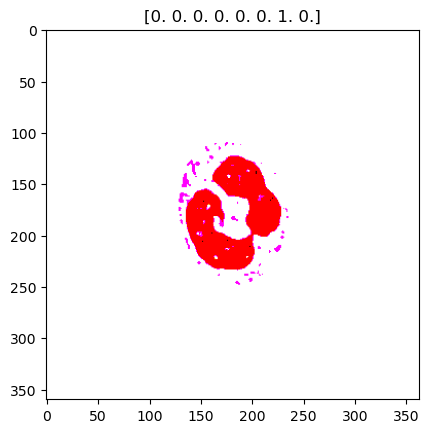

In [11]:
# Select a random image from the batch
idx =  random.randint(0, images.shape[0] - 1)

# Display the image
plt.imshow(images[idx])
plt.title(labels[idx])
plt.show()

In [12]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the convolutional base
base_model.trainable = False

2025-05-20 05:17:55.023961: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1387s 3s/step - accuracy: 0.7858 - loss: 0.6333 - val_accuracy: 0.8933 - val_loss: 0.3423
Epoch 2/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1394s 3s/step - accuracy: 0.8306 - loss: 0.4990 - val_accuracy: 0.9062 - val_loss: 0.2838
Epoch 3/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1385s 3s/step - accuracy: 0.8443 - loss: 0.4596 - val_accuracy: 0.9167 - val_loss: 0.2566
Epoch 4/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1362s 3s/step - accuracy: 0.8546 - loss: 0.4202 - val_accuracy: 0.9038 - val_loss: 0.2823
Epoch 5/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1331s 3s/step - accuracy: 0.8610 - loss: 0.4138 - val_accuracy: 0.9232 - val_loss: 0.2289
Epoch 6/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1324s 3s/step - accuracy: 0.8646 - loss: 0.3910 - val_accuracy: 0.9214 - val_loss: 0.2447
Epoch 7/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1287s 3s/step - accuracy: 0.8650 - loss: 0.3991 - val_accuracy: 0.9226 - val_loss: 0.2345
Epoch 8/10
428/428 ━━━━━━━━━━━━━━━━━━━━ 1275s 3s/step - accuracy: 0.8721 - loss: 0.3743 - 

In [22]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')

/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9471 - loss: 0.1680
Test accuracy: 94.76%


In [23]:
class_names = {0: 'basophil', 1: 'eosinophil', 2: 'erythroblast', 3:'ig', 4:'lymphocyte', 
               5:'monocyte', 6:'neutrophil', 7:'platelet'}

In [48]:
def predict_img(image,model):
    test_img=cv2.imread(image)
    test_img=cv2.resize(test_img, (363,360))
    test_img=np.expand_dims(test_img, axis=0)
    result=model.predict(test_img)
    r=np.argmax(result)
    print(class_names[r])

In [50]:
predict_img('/home/paulo/IA/image_recognition/test/platelet/PLATELET_141417.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
platelet


In [37]:
#Saving model
model.save('CropModel.keras')